Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 64, 64, 1)]          0         []                            
                                                                                                  
 conv2d_55 (Conv2D)          (None, 64, 64, 64)           640       ['input_6[0][0]']             
                                                                                                  
 conv2d_56 (Conv2D)          (None, 64, 64, 64)           36928     ['conv2d_55[0][0]']           
                                                                                                  
 max_pooling2d_13 (MaxPooli  (None, 32, 32, 64)           0         ['conv2d_56[0][0]']           
 ng2D)                                                                                      

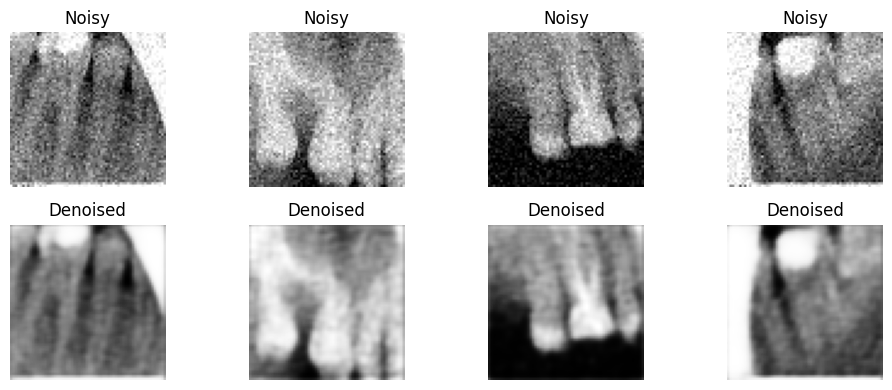

In [6]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input, BatchNormalization, Dropout, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Function to read dental images
def read_dental(folder="/content/dental"):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            images.append(img)
    return np.array(images)

# Function to read all datasets
def read_all_datasets():
    y = read_dental()
    return y

# Define the U-Net model
def unet_model(img_width=64, img_height=64):
    inputs = Input((img_width, img_height, 1))

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)

    # Decoder
    u5 = UpSampling2D((2, 2))(c4)
    u5 = concatenate([u5, c3])
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(u5)
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(c5)

    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c2])
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c1])
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(c7)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c7)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

# Define the CNN denoiser class
class CNN_denoiser:
    def __init__(self, batch_size=10, nu_epochs=50, validation_split=0, img_height=64, img_width=64):
        self.batch_size = batch_size
        self.nu_epochs = nu_epochs
        self.validation_split = validation_split
        self.model = unet_model(img_width=img_width, img_height=img_height)

    def model_plots(self, noise_prop, noise_mean, noise_std):
        # summarize history for loss
        plt.figure()
        plt.plot(np.arange(0, self.nu_epochs), self.model.history.history["loss"], label="train_loss")
        if self.validation_split != 0:
            plt.plot(np.arange(0, self.nu_epochs), self.model.history.history["val_loss"], label="val_loss")
        plt.title("Model Loss on Dataset\nNoise Proportion: {0} - Mean: {1} - Standard Deviation: {2}".format(noise_prop, noise_mean, noise_std))
        plt.xlabel("Epoch #")
        plt.ylabel("Loss")
        plt.legend(loc="lower left")
        plt.show()

    def train(self, noisy_input, pure, save=False, verbosity=0):
        self.model.fit(noisy_input, pure, epochs=self.nu_epochs, batch_size=self.batch_size, validation_split=self.validation_split, verbose=verbosity)
        if save:
            self.model.save("trainedModel.h5")

    def evaluate(self, noisy_input_test, pure_test):
        test_scores = self.model.evaluate(noisy_input_test, pure_test, verbose=2)
        print("[EVALUATION] Test loss:", test_scores[0])
        print("[EVALUATION] Test accuracy:", test_scores[1])
        return test_scores

    def predict(self, samples):
        return self.model.predict(samples)

if __name__ == "__main__":
    img_width, img_height = 64, 64
    batch_size = 10
    nu_epochs = 10
    validation_split = 0
    train_split = 0.9
    verbosity = 1
    noise_prop = 0.1
    noise_std = 1
    noise_mean = 0
    number_of_samples = 4
    shuffle_test_set = False
    save_results = False
    plot_results = True

    # Load and preprocess the dataset
    x = read_all_datasets()
    x = np.array([cv2.resize(img, (img_width, img_height)) for img in x])
    x = x.astype('float32') / 255.0  # Normalize the images

    # Split the dataset into training and test sets
    train_size = int(len(x) * train_split)
    x_train, x_test = x[:train_size], x[train_size:]

    # Add noise to the images
    noisy_x_train = x_train + noise_prop * np.random.normal(noise_mean, noise_std, x_train.shape)
    noisy_x_test = x_test + noise_prop * np.random.normal(noise_mean, noise_std, x_test.shape)
    noisy_x_train = np.clip(noisy_x_train, 0., 1.)
    noisy_x_test = np.clip(noisy_x_test, 0., 1.)

    # Expand dimensions to match the input shape of the network
    x_train = np.expand_dims(x_train, axis=-1)
    x_test = np.expand_dims(x_test, axis=-1)
    noisy_x_train = np.expand_dims(noisy_x_train, axis=-1)
    noisy_x_test = np.expand_dims(noisy_x_test, axis=-1)

    # Create the model
    cnn_denoiser = CNN_denoiser(batch_size=batch_size, nu_epochs=nu_epochs, validation_split=validation_split, img_height=img_height, img_width=img_width)

    # Train the model
    print("[LOG] Training and evaluating model...")
    cnn_denoiser.train(noisy_x_train, x_train, verbosity=verbosity)
    test_scores = cnn_denoiser.evaluate(noisy_x_test, x_test)

    # Generate denoised images
    print("[LOG] Denoising images...")
    denoised_images = cnn_denoiser.predict(noisy_x_test)

    # Plot noisy and denoised samples
    plt.figure(figsize=(10, 4))
    for i in range(number_of_samples):
        plt.subplot(2, number_of_samples, i + 1)
        plt.imshow(noisy_x_test[i].reshape(img_width, img_height), cmap='gray')
        plt.title("Noisy")
        plt.axis('off')

        plt.subplot(2, number_of_samples, i + 1 + number_of_samples)
        plt.imshow(denoised_images[i].reshape(img_width, img_height), cmap='gray')
        plt.title("Denoised")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Optional: Save denoised images
    if save_results:
        print("[LOG] Saving denoised images...")
        for i in range(len(denoised_images)):
            cv2.imwrite(f"denoised_image_{i}.png", (denoised_images[i].reshape(img_width, img_height) * 255).astype(np.uint8))
